In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2

## cuda and other setting

In [2]:
# Initial Settings
EPOCHS = 10
BATCH_SIZE = 8
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 800
label_dict = {'vehicle':1, 'pedestrian':2, 'scooter':3, 'bicycle':4}

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:1


## utils

In [3]:
def plot_result(filename, boxes, reshape=False) :
    filename = '../ivslab_train/JPEGImages/' + filename
    img = cv2.imread(filename)
    
    if reshape:
        img = cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT))
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        box = box.astype(np.int32)
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],
                                    linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    ax.set_axis_off()
    print(img.shape)
    ax.imshow(img)

(1080, 1920, 3)


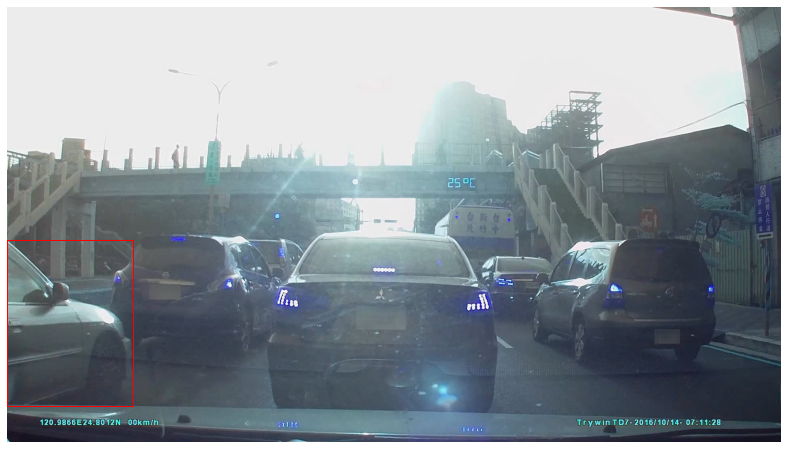

In [4]:
boxes = np.array([[0, 578, 313, 991]])
filename = 'All/FILE2191_02.mp4/FILE2191_02.mp4_00991.jpg'
plot_result(filename,boxes)

## read data and EDA

In [5]:
df = pd.read_json('data.json')
df.head()

,filename,labels,boxes,img_height,img_width
0,All/FILE2191_02.mp4/FILE2191_02.mp4_00991.jpg,"[vehicle, pedestrian, scooter, vehicle, vehicl...","[[0, 578, 313, 991], [717, 339, 739, 394], [20...",1080,1920
1,All/FILE2191_02.mp4/FILE2191_02.mp4_00577.jpg,"[scooter, vehicle, vehicle, vehicle, vehicle, ...","[[1679, 569, 1859, 870], [0, 578, 313, 991], [...",1080,1920
2,All/FILE2191_02.mp4/FILE2191_02.mp4_00088.jpg,"[scooter, vehicle, pedestrian, vehicle, vehicl...","[[195, 614, 269, 671], [0, 578, 313, 991], [10...",1080,1920
3,All/FILE2191_02.mp4/FILE2191_02.mp4_00815.jpg,"[vehicle, pedestrian, vehicle, vehicle, vehicl...","[[0, 578, 313, 991], [419, 349, 441, 403], [13...",1080,1920
4,All/FILE2191_02.mp4/FILE2191_02.mp4_01277.jpg,"[vehicle, pedestrian, vehicle, vehicle, pedest...","[[0, 578, 313, 991], [1228, 347, 1249, 401], [...",1080,1920


In [6]:
df.groupby('img_width').size()

img_width
1920    89002
dtype: int64

In [7]:
# xmin,ymin,xmax,ymax
df.iloc[0]['boxes']

[[0, 578, 313, 991],
 [717, 339, 739, 394],
 [207, 614, 270, 662],
 [1300, 572, 1758, 892],
 [1155, 616, 1369, 770],
 [411, 346, 431, 403],
 [255, 561, 687, 868],
 [1070, 329, 1094, 392],
 [644, 554, 1218, 1014]]

### reshape 

In [8]:
def reshape_box(row):
    # a = row['boxes']
    for i in row:
        i[0] = i[0]*(IMAGE_WIDTH / 1920)
        i[2] = i[2]*(IMAGE_WIDTH / 1920)
        i[1] = i[1]*(IMAGE_HEIGHT / 1080)
        i[3] = i[3]*(IMAGE_HEIGHT / 1080)
    return row

#
def add_boundary(row):
    # a = row['boxes']
    for i in row:
        if int(i[0])==0: i[0] = 1
        if int(i[1])==0: i[0] = 1
        if int(i[2])==IMAGE_WIDTH : i[2] = IMAGE_WIDTH-1
        if int(i[3])==IMAGE_HEIGHT : i[3] = IMAGE_HEIGHT-1
    return row

In [9]:
df['boxes'] = df['boxes'].apply(reshape_box)
#df['boxes'] = df['boxes'].apply(add_boundary)

(800, 800, 3)


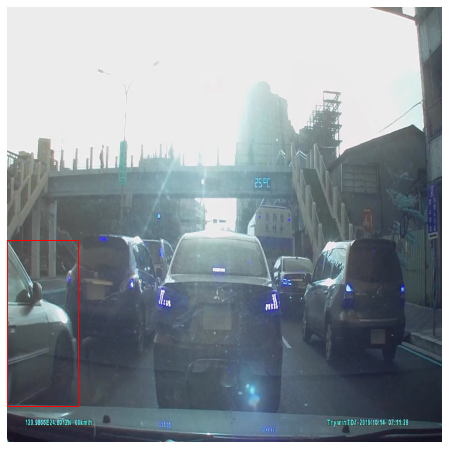

In [10]:
boxes = np.array([df.iloc[0]['boxes'][0]])
filename = 'All/FILE2191_02.mp4/FILE2191_02.mp4_00991.jpg'
plot_result(filename,boxes,True)

['vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle']
(800, 800, 3)
All/FILE3567_02.mp4/FILE3567_02.mp4_01057.jpg


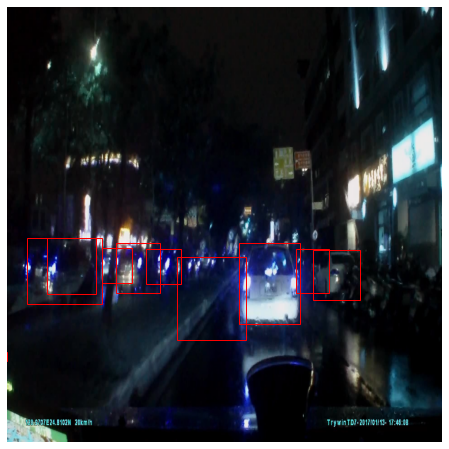

In [11]:
idx = 9146
boxes = np.array(df.iloc[idx]['boxes'])
print(df.iloc[idx]['labels'])
filename = df.iloc[idx]['filename']
plot_result(filename,boxes,True)
print(filename)

### Check and remove invalid data

In [12]:
bb = df['boxes'].values
lb = df['labels'].values

In [13]:
## first check
for idx,bs in enumerate(bb):
    for b in bs:
        #if b[0]>=128 or b[1]>=128 or b[2]>=128 or b[3]>=128:
        if b[0] >= b[2] or b[1] >= b[3]:
            print('error {}'.format(idx))

error 8979
error 9146
error 9166
error 9170
error 9181
error 9309
error 9386
error 9596
error 9607
error 9628
error 9633
error 9931
error 10117
error 10170
error 10233
error 10299
error 10445
error 74742


In [14]:
## remove invalid element
for boxes, labels in zip(bb,lb):
    size = len(labels)
    i = 0
    while(i<size):
        if boxes[i][0] >= boxes[i][2] or boxes[i][1] >= boxes[i][3]:
            boxes.remove(boxes[i])
            labels.remove(labels[i])
            size = size - 1
        i = i+1        

In [15]:
## final check
for idx,bs in enumerate(bb):
    for b in bs:
        #if b[0]>=128 or b[1]>=128 or b[2]>=128 or b[3]>=128:
        if b[0] >= b[2] or b[1] >= b[3]:
            print('error {}'.format(idx))                

### to tensor

In [16]:
targets=list()
for index, row in df.iterrows():
    d, item = {},{}
    d['name'] = row['filename']
    np_boxes = np.array(df.iloc[index]['boxes'])
    item['boxes'] = torch.from_numpy(np_boxes).type(torch.float32)
    np_labels = np.array(list(map(lambda s: label_dict[s], df.iloc[index]['labels'])))
    item['labels'] = torch.from_numpy(np_labels).type(torch.int64)
    d['items'] = item
    targets.append(d)

In [17]:
targets[0]['items']

{'boxes': tensor([[  0.0000, 428.1482, 130.4167, 734.0741],
         [298.7500, 251.1111, 307.9167, 291.8518],
         [ 86.2500, 454.8148, 112.5000, 490.3704],
         [541.6667, 423.7037, 732.5000, 660.7407],
         [481.2500, 456.2963, 570.4167, 570.3704],
         [171.2500, 256.2963, 179.5833, 298.5185],
         [106.2500, 415.5555, 286.2500, 642.9630],
         [445.8333, 243.7037, 455.8333, 290.3704],
         [268.3333, 410.3704, 507.5000, 751.1111]]),
 'labels': tensor([1, 2, 3, 1, 1, 2, 1, 2, 1])}

## preprocess

### create dataset

In [18]:
class ImgDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, targets, transform=None):
        """
        Args:
            targets = dict that have bbox data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.targets = targets
        self.transform = transform
        self.label_dict = {'vehicle':1, 'pedestrian':2, 'scooter':3, 'bicycle':4}

    def __len__(self):
        return len((self.targets))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image_dir = '../ivslab_train/JPEGImages/'
        img_name = image_dir + self.targets[idx]['name']        
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        labels =self.targets[idx]['items']

        return image,labels

In [19]:
image_size = (IMAGE_WIDTH,IMAGE_HEIGHT)
normalize = ((0.5), (0.5))
transform = transforms.Compose([transforms.ToTensor()])# [0-255] -> [0-1]

# transform for reshape version
transform2 = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor()])# [0-255] -> [0-1]

C2_dataset = ImgDataset(targets,transform2)

print(C2_dataset[0][0].shape)
print(C2_dataset[0][1])

torch.Size([3, 800, 800])
{'boxes': tensor([[  0.0000, 428.1482, 130.4167, 734.0741],
        [298.7500, 251.1111, 307.9167, 291.8518],
        [ 86.2500, 454.8148, 112.5000, 490.3704],
        [541.6667, 423.7037, 732.5000, 660.7407],
        [481.2500, 456.2963, 570.4167, 570.3704],
        [171.2500, 256.2963, 179.5833, 298.5185],
        [106.2500, 415.5555, 286.2500, 642.9630],
        [445.8333, 243.7037, 455.8333, 290.3704],
        [268.3333, 410.3704, 507.5000, 751.1111]]), 'labels': tensor([1, 2, 3, 1, 1, 2, 1, 2, 1])}


In [20]:
#89002

train_set, val_set = random_split(C2_dataset, [80000, 9002],generator=torch.Generator().manual_seed(42))

# 對 dataloader batch做最後處理的函式，不加會crash，原因我還沒搞懂
def collate_fn(batch):
    return tuple(zip(*batch))

# create train val loader
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, collate_fn=collate_fn)

valloader = DataLoader(val_set, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, collate_fn=collate_fn)

## Define Model And Setting

In [21]:
# num_classes which is user-defined
num_classes = 4+1  # 4 class (digit) + background

model_ft = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = num_classes)

'''
# get number of input features for the classifier
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
'''

'\n# get number of input features for the classifier\nin_features = model_ft.roi_heads.box_predictor.cls_score.in_features\n\n# replace the pre-trained head with a new one\nmodel_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)\n'

### Traing Setting

In [22]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [23]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    
    loss_hist = Averager()
    itr = 1
    
    for epoch in range(num_epochs):
        loss_hist.reset()
        
        for images, targets in trainloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)


            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 500 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1

        # update the learning rate
        if scheduler is not None:
            scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}") 
        PATH = f'model/pytorch_retinanet_{epoch}'
        torch.save(model_ft.state_dict(), PATH)
    return model

In [24]:
model_ft = model_ft.to(device)

params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer_ft = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=9, gamma=0.1)

In [25]:
model_ft.train()
model_ft = train_model(model_ft, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iteration #500 loss: 1.1412649154663086
Iteration #1000 loss: 0.9669227004051208
Iteration #1500 loss: 0.7981008887290955
Iteration #2000 loss: 0.6363859176635742
Iteration #2500 loss: 0.8018239736557007
Iteration #3000 loss: 0.5330756306648254
Iteration #3500 loss: 0.43955570459365845
Iteration #4000 loss: 0.4183211028575897
Iteration #4500 loss: 0.4266778826713562
Iteration #5000 loss: 0.48255395889282227
Iteration #5500 loss: 0.37735188007354736
Iteration #6000 loss: 0.4816748797893524
Iteration #6500 loss: 0.3685472011566162
Iteration #7000 loss: 0.3639494478702545
Iteration #7500 loss: 0.3686513304710388
Iteration #8000 loss: 0.4504042863845825
Iteration #8500 loss: 0.42195695638656616
Iteration #9000 loss: 0.22927510738372803
Iteration #9500 loss: 0.3413342237472534
Iteration #10000 loss: 0.35624706745147705
Epoch #0 loss: 0.538605969965458
Iteration #10500 loss: 0.28736412525177
Iteration #11000 loss: 0.281742662191391
Iteration #11500 loss: 0.270888090133667
Iteration #12000 lo

Iteration #93500 loss: 0.12914735078811646
Iteration #94000 loss: 0.07567568123340607
Iteration #94500 loss: 0.09834333509206772
Iteration #95000 loss: 0.1341082751750946
Iteration #95500 loss: 0.10522669553756714
Iteration #96000 loss: 0.1402777135372162
Iteration #96500 loss: 0.08723477274179459
Iteration #97000 loss: 0.09723124653100967
Iteration #97500 loss: 0.11640238761901855
Iteration #98000 loss: 0.0832492932677269
Iteration #98500 loss: 0.08098060637712479
Iteration #99000 loss: 0.1089053750038147
Iteration #99500 loss: 0.09915155172348022
Iteration #100000 loss: 0.08102928102016449
Epoch #9 loss: 0.11091334251128138


### save model

In [ ]:
PATH = f'model/pytorch_retinanet'
torch.save(model_ft.state_dict(), PATH)

## Demo

In [29]:
LOAD_MODEL = True

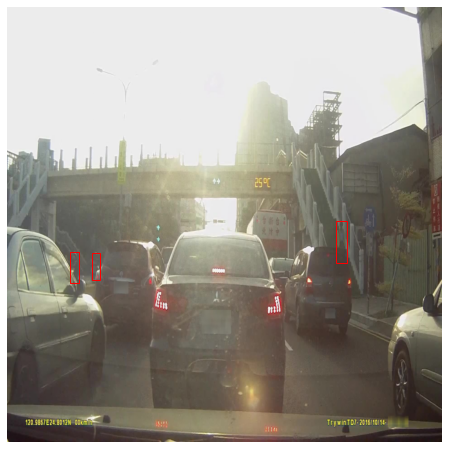

In [31]:
## get output
if LOAD_MODEL:
    model_ft.load_state_dict(torch.load(PATH))
model_ft.eval()
sample = [train_set[0][0].to(device)]
output = model_ft(sample)
output = [{k: v.to('cpu') for k, v in t.items()} for t in output]

sample_show = sample[0].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for pred in output:
    for box in pred['boxes'].detach().numpy().astype(np.int32)[0:3]:
            rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

ax.set_axis_off()


ax.imshow(sample_show)
plt.show()

In [32]:
output

[{'boxes': tensor([[604.9590, 394.4579, 625.4010, 471.6110],
          [115.9101, 451.1254, 131.0681, 507.3120],
          [156.1676, 452.2905, 171.4383, 502.3205],
          [108.3718, 454.2636, 123.2747, 507.2288],
          [162.0034, 451.3371, 177.4631, 499.9514]], grad_fn=<CopyBackwards>),
  'labels': tensor([3, 1, 1, 1, 1]),
  'scores': tensor([0.9992, 0.9954, 0.9254, 0.4673, 0.0983], grad_fn=<CopyBackwards>)}]

In [36]:
sample[0].shape

torch.Size([3, 800, 800])